In [8]:
import Parity_Data_Generator
import InputToParityESN
# import ParityToOutputESN
import numpy as np
from pyESN import ESN
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import time

rng = np.random.RandomState(42)

In [9]:
N = 20000   # number of datapoints
n = 3       # n-parity

start_time = time.time()
# produce Data
bits, parity, target = Parity_Data_Generator.generateParityData(N, n, randomstate=rng)

# Divide in training and test data
traintest_cutoff = int(np.ceil(0.7 * len(bits)))
train_bits, test_bits = bits[:traintest_cutoff], bits[traintest_cutoff:]
train_parity, test_parity = parity[:traintest_cutoff], parity[traintest_cutoff:]
train_targets, test_targets = target[:traintest_cutoff], target[traintest_cutoff:]

print("--- %s seconds ---" % (time.time() - start_time))

--- 9.056209564208984 seconds ---


In [10]:
def runSomeConfigs(spectral_rad, leak_r,num_neurons=500):
#     print("Spectral-radius:",spectral_rad, "leak-rate:", leak_r)
    nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=num_neurons,  # from 200 onwards test error decreases significantly
                          spectral_radius=spectral_rad,  # from 0.9 the test error is 0.0
                          leak_rate= leak_r,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.001,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          out_activation=np.tanh,
                          inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
    # print(np.shape(bits),np.shape(parity),np.shape(target))
    nParityESN.fit(train_bits, train_parity)
    pred_test = nParityESN.predict(test_bits)

#     #### not rounding
#     predictedParity = pred_test # not rounding
    #### Rounding
    better_pred_test = []           # Maybe don't round and return "true" results from pred_test
    for x in pred_test:
        better_pred_test.append(0 if x < 0.5 else 1)
    predictedParity = np.array(better_pred_test).reshape(-1,1)
#     print(test_parity[40030:40100].reshape(-1))
#     print(predictedParity[40030:40100].reshape(-1))
    
    print("Testing error")
    test_error = np.sqrt(np.mean((predictedParity - test_parity) ** 2))
    print(test_error)
    return test_error


In [13]:
# num_neurons = [500, 600, 700, 800, 900, 1000]
# num_neurons = [500]
num_neurons = [100, 200, 300, 400, 500]
# l_rate = np.linspace(0.01, 0.2, num=20)
l_rate =[0.1, 0.125, 0.15, 0.175, 0.2]
sp_rad = np.linspace(0.7, 1.0, num=4)

run_time = time.time()
iterations, iterationcount = len(num_neurons)*len(sp_rad)*len(l_rate), 0
leak_rate_list = []
spectral_radius_list = []
errors = []
all_errors = [{} for _ in range(len(num_neurons))]
for i,n in enumerate(num_neurons):
    leak_rate_list = []
    spectral_radius_list = []
    errors = []
    for l in l_rate:
        for s in sp_rad:
            print("Neurons:", n, "Spectral-radius:", s, "Leak-rate:", l)
            leak_rate_list.append(l)
            spectral_radius_list.append(s)
            errors.append(runSomeConfigs(s,l,n))
            iterationcount = iterationcount + 1
            print("--- Progress: {:.2f}% --- {:.2f} minutes ---".format(iterationcount/iterations*100, ((time.time() - run_time)/60) ))
    ## Save leak-rate,spectral-radius and error in dictionary
    all_errors[i] = leak_rate_list, spectral_radius_list, errors
            
print("Total time for Testbench:")
print("--- {:.2f} seconds ---".format(time.time() - run_time))
print("--- {:.2f} minutes ---".format(((time.time() - run_time)/60)))

Neurons: 100 Spectral-radius: 0.7 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.200946099786
Testing error
0.652431350156
--- Progress: 1.00% --- 0.16 minutes ---
Neurons: 100 Spectral-radius: 0.8 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.19222074375
Testing error
0.705887935708
--- Progress: 2.00% --- 0.31 minutes ---
Neurons: 100 Spectral-radius: 0.9 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.195112899151
Testing error
0.389051553282
--- Progress: 3.00% --- 0.45 minutes ---
Neurons: 100 Spectral-radius: 1.0 Leak-rate: 0.1
harvesting states...
fitting...
training error:
0.202543760308
Testing error
0.386077136795
--- Progress: 4.00% --- 0.60 minutes ---
Neurons: 100 Spectral-radius: 0.7 Leak-rate: 0.125
harvesting states...
fitting...
training error:
0.182462235598
Testing error
0.437734064371
--- Progress: 5.00% --- 0.75 minutes ---
Neurons: 100 Spectral-radius: 0.8 Leak-rate: 0.125
harvesting states...
fitting...
traini

In [50]:
# import pickle
#### Save Data
# pickle.dump(all_errors, open("datasave.p", "wb"))
#### Load Data
# all_errors = pickle.load(open("datasave.p", "rb"))

<IPython.core.display.Javascript object>


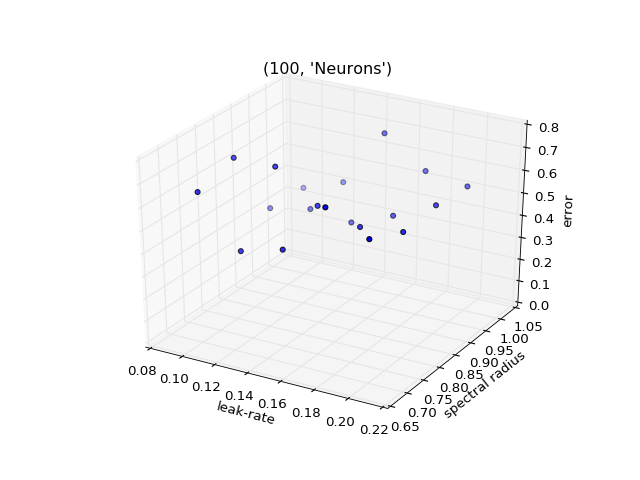

<IPython.core.display.Javascript object>


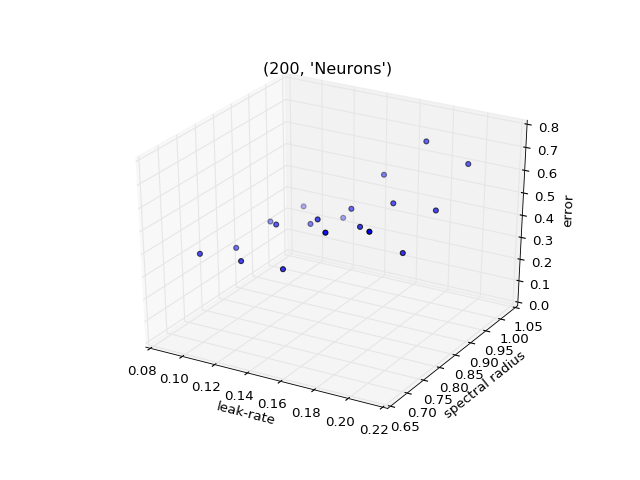

<IPython.core.display.Javascript object>


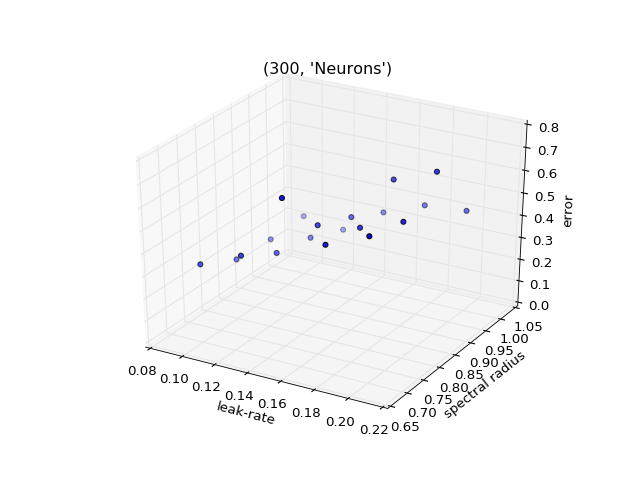

<IPython.core.display.Javascript object>


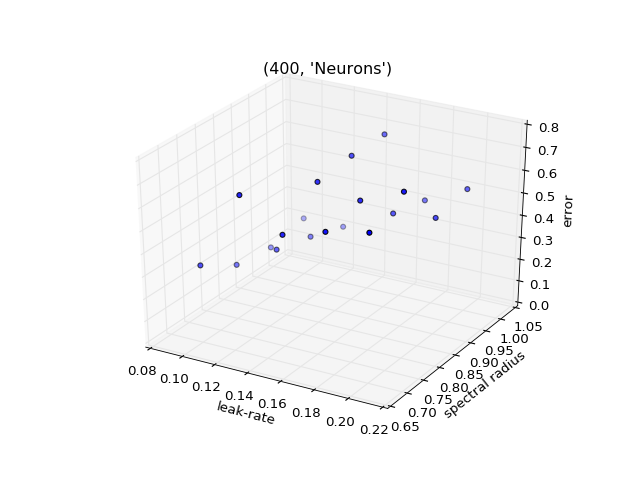

<IPython.core.display.Javascript object>


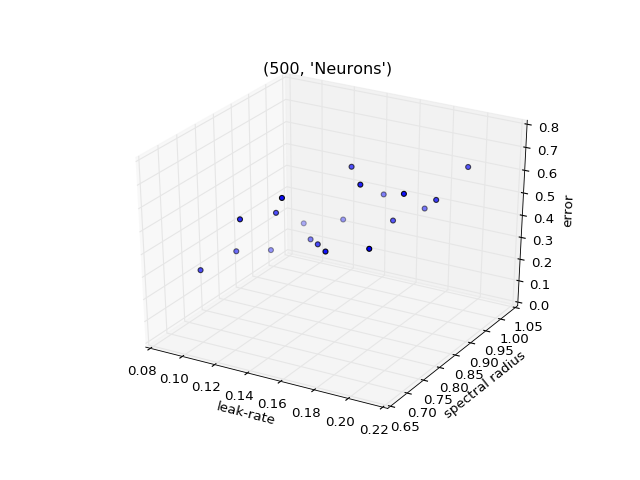

In [41]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


for i, n in enumerate(all_errors):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x, y, z = all_errors[i]
    
    ax.set_zlim(0, 0.8)
    ax.scatter(x, y, z)
    
    ax.set_title((num_neurons[i], "Neurons"))
    ax.set_xlabel('leak-rate')
    ax.set_ylabel('spectral radius')
    ax.set_zlabel('error')

plt.show()

<IPython.core.display.Javascript object>


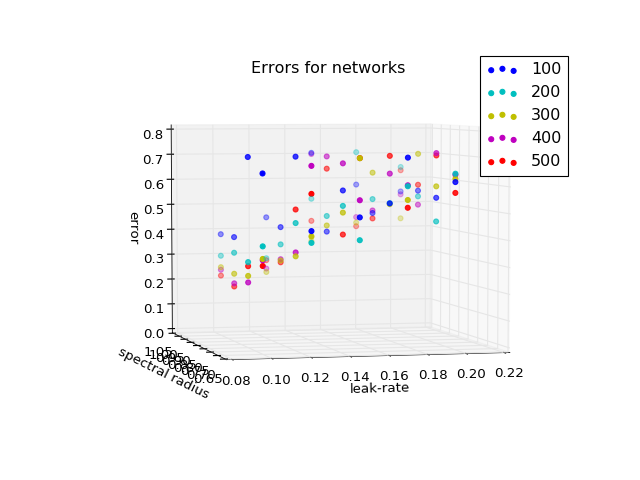

In [49]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

colors=['b', 'c', 'y', 'm', 'r']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for i, n in enumerate(all_errors):

    x, y, z = all_errors[i]
    
    ax.set_zlim(0, 0.8)
    ax.scatter(x, y, z, color=colors[i], label=(num_neurons[i]))
    
    ax.set_xlabel('leak-rate')
    ax.set_ylabel('spectral radius')
    ax.set_zlabel('error')
ax.set_title("Errors for networks")
ax.legend()
plt.show()

In [ ]:
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('HansBambel', 'T0F76G8esWCDFNmIVEUv')

x = leak_rate_list
y = spectral_radius_list
z = errors

# for i in sp_rad:
#     x.extend(l_rate)
# for i in l_rate:
#     y.extend(sp_rad)
    
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=12,
        color=z,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(
#     margin=dict(
#         l=0,
#         r=0,
#         b=0,
#         t=0
#     )
    scene=go.Scene(
        xaxis=go.XAxis(title='x = Leak-Rate'),
        yaxis=go.YAxis(title='y = Spectral Radius'),
        zaxis=go.ZAxis(title='z = Error')
        )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-scatter-errors')

print("### Input-->Parity ###")
run_time = time.time()
# get good configs for a slow ESN
nParityESN = ESN(n_inputs=1,
                          n_outputs=1,
                          n_reservoir=500,  # from 200 onwards test error decreases significantly
                          spectral_radius=0.95,  # from 0.9 the test error is 0.0
                          leak_rate= 0.5,   # adjust leak_rate
                          sparsity=0.95,
                          noise=0.001,
                          input_shift=0,
                          input_scaling=3,  # 3 seems to be fine. Maybe use lower
                          teacher_scaling=1.12,
                          teacher_shift=-0.7,
                          out_activation=np.tanh,
                          inverse_out_activation=np.arctanh,
                          random_state=rng,
                          silent=False)
# print(np.shape(bits),np.shape(parity),np.shape(target))
nParityESN.fit(train_bits, train_parity)
pred_test = nParityESN.predict(test_bits)

#### Rounding
better_pred_test = []           # Maybe don't round and return "true" results from pred_test
for x in pred_test:
    better_pred_test.append(0 if x < 0.5 else 1)
predictedParity = np.array(better_pred_test).reshape(-1,1)

print("Testing error")
print(np.sqrt(np.mean((predictedParity - test_parity) ** 2)))

print("--- %s seconds ---" % (time.time() - run_time))
print("--- %s minutes ---" % (((time.time() - run_time)/60)))